In [7]:
def _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn):
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

        t = range(x.size)
        ax1.plot(t, x, 'b-', lw=2)
        if len(ta):
            ax1.plot(ta, x[ta], 'o', mfc='r', mec='r', mew=1, ms=5,
                     label='Alarm')
            ax1.legend(loc='best', framealpha=.5, numpoints=1)
        ax1.set_xlim(-.01*x.size, x.size*1.01-1)
        ax1.set_xlabel('Data #', fontsize=14)
        ax1.set_ylabel('Amplitude', fontsize=14)
        ax1.set_title('Time series and detected changes ' +
                      '(threshold= %.3g, drift= %.3g): '
                      % (threshold, drift))
        ax2.plot(t, gp, 'y-', label='+')
        ax2.plot(t, gn, 'm-', label='-')
        ax2.set_xlim(-.01*x.size, x.size*1.01-1)
        ax2.set_xlabel('Data #', fontsize=14)
        ax2.axhline(threshold, color='r')
        ax1.set_ylabel('Amplitude', fontsize=14)
        ax2.set_title('Time series of the cumulative sums of ' +
                      'positive and negative changes')
        ax2.legend(loc='best', framealpha=.5, numpoints=1)
        plt.tight_layout()
        plt.show()

In [8]:
import numpy as np

def detect_cusum(x, threshold=1, drift=0, ending=False, show=True, ax=None):
    x = np.atleast_1d(x).astype('float64')
    gp, gn = np.zeros(x.size), np.zeros(x.size)
    ta, tai, taf = np.array([[], [], []], dtype=int)
    tap, tan = 0, 0
    amp = np.array([])
    
    for i in range(1, x.size):
        s = x[i] - x[i-1]
        gp[i] = gp[i-1] + s - drift  
        gn[i] = gn[i-1] - s - drift  
        if gp[i] < 0:
            gp[i], tap = 0, i
        if gn[i] < 0:
            gn[i], tan = 0, i
        if gp[i] > threshold or gn[i] > threshold:  
            ta = np.append(ta, i)   
            tai = np.append(tai, tap if gp[i] > threshold else tan)  
            gp[i], gn[i] = 0, 0      
  
    if tai.size and ending:
        _, tai2, _, _ = detect_cusum(x[::-1], threshold, drift, show=False)
        taf = x.size - tai2[::-1] - 1
        
        tai, ind = np.unique(tai, return_index=True)
        ta = ta[ind]
        
        if tai.size != taf.size:
            if tai.size < taf.size:
                taf = taf[[np.argmax(taf >= i) for i in ta]]
            else:
                ind = [np.argmax(i >= ta[::-1])-1 for i in taf]
                ta = ta[ind]
                tai = tai[ind]
        
        ind = taf[:-1] - tai[1:] > 0
        if ind.any():
            ta = ta[~np.append(False, ind)]
            tai = tai[~np.append(False, ind)]
            taf = taf[~np.append(ind, False)]
       
        amp = x[taf] - x[tai]

    if show:
        _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn)

    return ta, tai, taf, amp

In [9]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

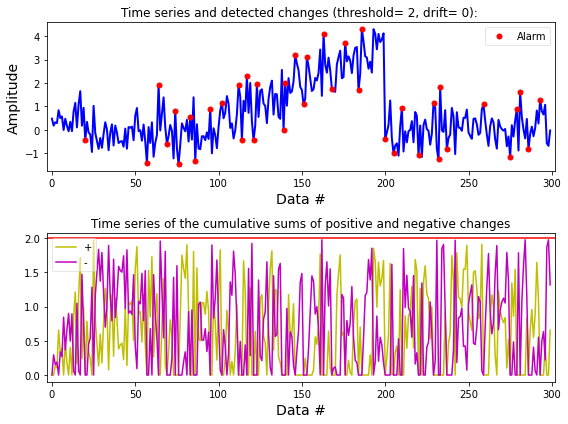

In [10]:
x = np.random.randn(300)/1.5
x[100:200] += np.arange(0, 4, 4/100)
ta, tai, taf, amp = detect_cusum(x, 2, 0, True, True)

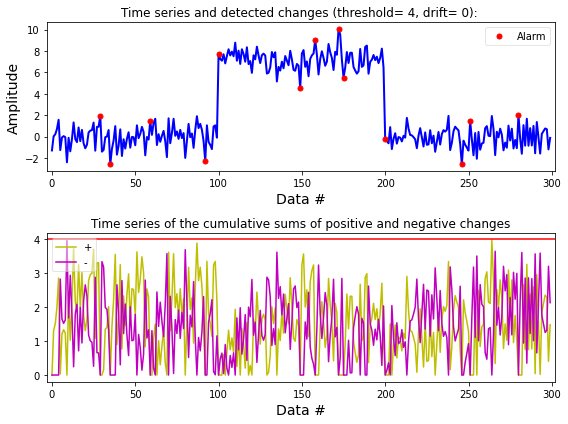

(array([ 29,  35,  59,  92, 100, 149, 158, 172, 175, 200, 246, 251, 280]),
 array([  9,  29,  35,  87,  92, 110, 149, 160, 172, 189, 238, 246, 255]),
 array([], dtype=int64),
 array([], dtype=float64))

In [11]:
x = np.random.randn(300)
x[100:200] += 7
detect_cusum(x, 4, 0, False, True)

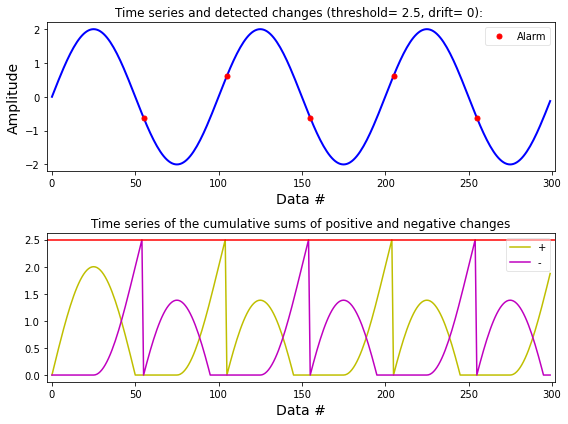

In [12]:
x = 2*np.sin(2*np.pi*np.arange(0, 3, .01))
ta, tai, taf, amp = detect_cusum(x, 2.5, 0, True, True)